In [1]:
import pandas as pd
import numpy as np
import scipy.sparse
import scipy.stats
import sklearn.metrics
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering, AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage, dendrogram
import os, gc, re
import pylab as pl
import seaborn as sns
from time import time

%matplotlib inline
pl.rcParams['figure.figsize'] = 10, 5
pd.__version__, sklearn.__version__, np.__version__

('0.18.0', '0.17.1', '1.11.0')

In [4]:
def memory_usage(df, ret=False, print_usage=True):
    if type(df) == pd.core.frame.DataFrame:
        m = df.memory_usage(index=True, deep=True).sum()/2**20
    elif type(df) == np.ndarray:
        m = df.nbytes/2**20
    else:
        m = df.data.nbytes/2**20
    if print_usage:
        print(m, 'Mb,', 'with shape =', df.shape)
    if ret:
        return m

In [5]:
def read_tosvmr(filename):
    if os.stat(filename).st_size == 0:
        return None
    df = pd.read_csv(filename, sep=' ', header=None)
    del df[7], df[6]
    df.columns = ['Rank', 'QueryID', 'CTR', 'CTP',
                  'Purchases', 'Turnover', 'ItemID']
    df.QueryID = df.QueryID.str.extract('qid:(\d+)').astype('int32')
    df.Rank = df.Rank.astype('int8')
    for i, col in enumerate(['CTR', 'CTP', 'Purchases', 'Turnover']):
        df[col] = df[col].str.extract(str(i+1) + ':(.+)').astype('float16')
    df.ItemID = df.ItemID.str.extract('item_id=(.+)')
    return df

In [ ]:
# data = pd.DataFrame()
# directory = '../data/svmr/'
# size = 0
# records = 0
# # max_Rank, max_QID, max_ItemID_len = 0, 0, 0 # (2, 309111, 36)
# # min_Rank, min_QID, min_ItemID_len = (2**63-1,)*3 # (1, 2, 36)
# for i, filename in enumerate([f for f in os.listdir(directory) if re.match('.+\.tosvmr', f)]):
#     chunk = read_tosvmr(os.path.join(directory, filename))
#     if chunk is not None:
#         qid = chunk.groupby('QueryID').Rank.agg('unique')
#         qids = chunk.groupby('QueryID').Rank.nunique() > 1
#         qids = set(qids[qids].index)
#         chunk = chunk.ix[chunk.QueryID.isin(qids), ['Rank', 'QueryID', 'ItemID']]
#         data = data.append(chunk)
#         size += memory_usage(chunk, ret=True, print_usage=False)
#         records += chunk.shape[0]
#         if i % 20 == 0:
#             print(i+1, 'file', filename)
#             print('memory =', size, 'Mb', 'Records =', records)
#     del chunk
# print('TOTAL', 'memory =', size, 'Mb. Records =', records)

In [ ]:
# data_filename = '../data/data.csv'
# data.to_csv(data_filename, index=False)


In [ ]:
# data = read_tosvmr('../data/svmr/111AF73E-67E3-4E6E-BB32-3A7FB9B2F08A.tosvmr')
# qid = data.groupby('QueryID').Rank.agg('unique')
# qids = data.groupby('QueryID').Rank.nunique() > 1
# qids = set(qids[qids].index)
# data = data.ix[data.QueryID.isin(qids)]
# memory_usage(data)
# data.head()

In [6]:
data_filename = '../data/data.csv'
data = pd.read_csv(data_filename, dtype={'QueryID': 'int32', 'Rank': 'int8'})
memory_usage(data)
data.head()

2035.01683998 Mb, with shape = (21774181, 3)


,Rank,QueryID,ItemID
0,1,3220,B4180163-1E4B-4B7C-975E-7C99444C777B
1,1,3220,C19DF510-FD11-41AD-A794-2A1A58A4B9EF
2,1,3220,3FAFD53D-066E-49FA-B1DD-34ED9E592A17
3,1,3220,5978FEBB-DB0D-4EE9-B2E8-C5CAFEE23279
4,1,3220,A31CFDA1-CFA2-4AA8-836D-783DBE451694


In [7]:
queryID_encoder, itemID_encoder = LabelEncoder(), LabelEncoder()
S = scipy.sparse.coo_matrix((data.Rank.values, 
                             (queryID_encoder.fit_transform(data.QueryID.values),
                              itemID_encoder.fit_transform(data.ItemID.values)))).tocsr().astype('int16')
memory_usage(S)


41.025251388549805 Mb, with shape = (66660, 405632)


In [8]:
del data
gc.collect()

109

### How many quieries have particular length of items?

In [ ]:
items_length = pd.Series(np.array(S.sum(axis=1)).reshape(S.shape[0]))
pl.hist(items_length, bins=100)
pl.xlabel('#items')
pl.ylabel('#users which have particular #items')
pl.savefig('../plots/user_number_items.png')


In [ ]:
def intersection_size(x, y):
    return len(set(x.indices).intersection(set(y.indices)))

In [113]:
intersection_matrix = sklearn.metrics.pairwise_distances(S[:3000], metric=intersection_size)
print('is there a nan value? ', np.isnan(intersection_matrix).any())
memory_usage(intersection_matrix)

 is there a nan value?  False
68.66455078125 Mb, with shape = (3000, 3000)


In [115]:
# intersection_matrix_filename = '../data/intersection_matrix3000.csv'
# np.savetxt(intersection_matrix_filename, intersection_matrix, delimiter=';', fmt='%g')
# print(intersection_matrix_filename, 'created')

In [ ]:
def plot_distance_values(distance_matrix, xlabel='distance', ret=False, bins=100, xlim=None, ylim=None):
    i, j = np.triu_indices(distance_matrix.shape[0])
    values = distance_matrix[i[i != j], j[j != i]]
    n, bins, patches = pl.hist(values, bins=bins)
    pl.xlabel(xlabel)
    pl.ylabel('number of pairs')
    if xlim:
        pl.xlim(xlim)
    if ylim:
        pl.ylim(ylim)
    if ret:
        return pd.Series(values)

In [10]:
# plot_distance_values(intersection_matrix, 'intersection size', bins=1000, ylim=[0,3000], xlim=[1,150])
# pl.savefig('../plots/intersection_sizes_zoomed.png'

# rewrite distance function

In [9]:
def distance_func(x, y, distance='kendall'):
    mask_x = np.in1d(x.indices, y.indices)
    mask_y = np.in1d(y.indices, x.indices)
    
    vector_x = x.data[mask_x]
    vector_y = y.data[mask_y]
    intersection_size = mask_x.sum()
    
    if intersection_size == 0:
        if distance in ['kendall', 'spearman']:
            return 3
        elif distance == 'euclidean':
            return np.sqrt(x.shape[1]*4)+1
    
    unique_x = np.unique(vector_x) 
    unique_y = np.unique(vector_y)
    if distance in ['kendall', 'spearman'] and unique_x.shape[0] == 1 and (
        unique_y.shape[0] == 1 and unique_x[0] == unique_y[0] == 1):
        return 3
    if distance in ['kendall', 'spearman'] and (unique_x.shape[0] == 1 or unique_y.shape[0] == 1):
        vector_x = np.append(vector_x, [0])
        vector_y = np.append(vector_y, [0])
    
    if distance == 'kendall':
        tau, pvalue = scipy.stats.kendalltau(vector_x, vector_y)
        return 1 - tau
    elif distance == 'spearman':
        tau, pvalue = scipy.stats.spearmanr(vector_x, vector_y)
        return 1 - tau
    elif distance == 'euclidean':
        return np.sqrt(np.sum((vector_x - vector_y)**2))

In [7]:
distance_matrix_filename = '../data/distance_matrix6000_kt.csv'
distance_matrix = np.loadtxt(distance_matrix_filename, delimiter=';')

In [15]:
n_queries = 10000
X = S[:n_queries, :]
# X = S

In [16]:
time_a = time()
distance_matrix = sklearn.metrics.pairwise_distances(X, metric=distance_func, n_jobs=-1)
print('it took', time() - time_a, 'seconds')
print('is there a nan value? ', np.isnan(distance_matrix).any())
memory_usage(distance_matrix)

it took 4972.173109292984 seconds
is there a nan value?  False
762.939453125 Mb, with shape = (10000, 10000)


In [17]:
distance_matrix_filename = '../data/distance_matrix10000_kt.csv'
np.savetxt(distance_matrix_filename, distance_matrix, delimiter=';', fmt='%g')
print(distance_matrix_filename, 'created')

../data/distance_matrix10000_kt.csv created


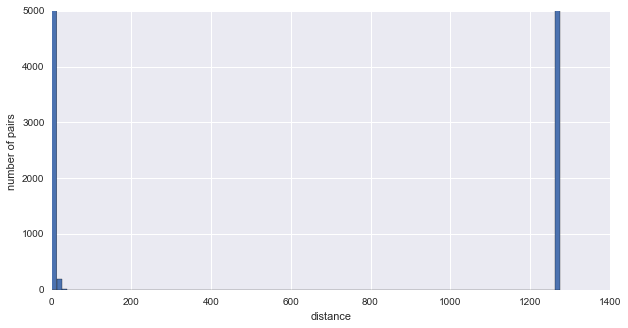

In [26]:
plot_distance_values(distance_matrix, bins=100, ylim=[0, 5000])

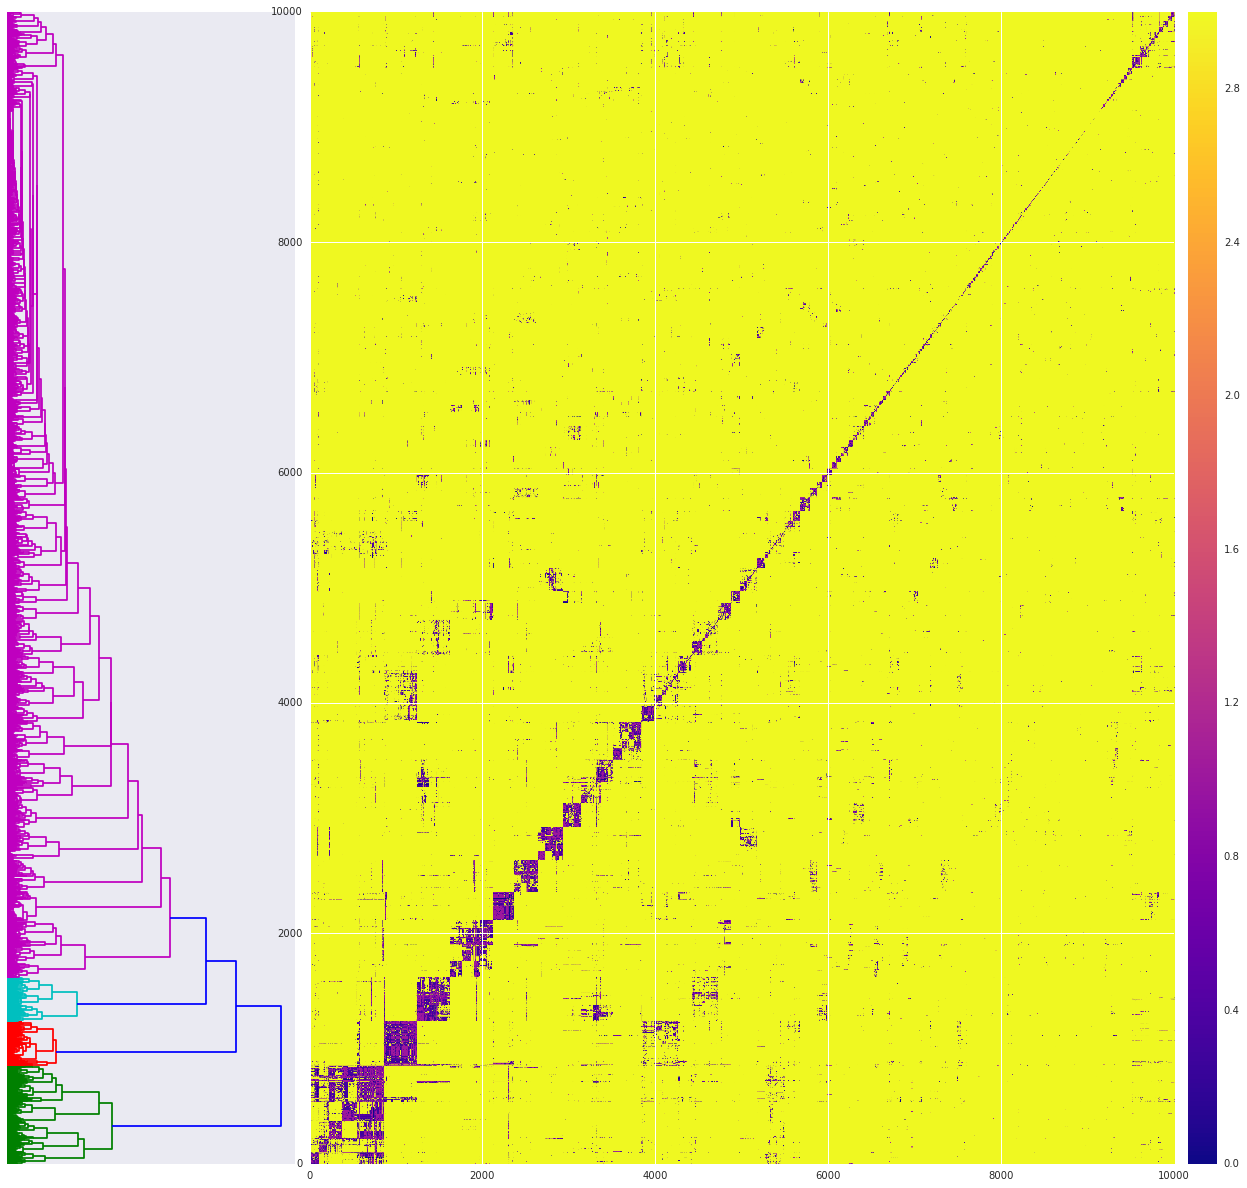

In [21]:
fig = pl.figure(figsize=(20, 20))
axdendro = fig.add_axes([0.09,0.1,0.2,0.8])
Y = sch.linkage(distance_matrix, method='ward')
Z = sch.dendrogram(Y, orientation='right')
axdendro.set_xticks([])
axdendro.set_yticks([])

# Plot distance matrix.
axmatrix = fig.add_axes([0.3,0.1,0.6,0.8])
index = Z['leaves']
new_distance_matrix = distance_matrix[index,:]
new_distance_matrix = new_distance_matrix[:,index]
im = pl.imshow(new_distance_matrix, aspect='auto', cmap='plasma', origin='lower')

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.8])
pl.colorbar(im, cax=axcolor)
pl.savefig('../plots/ward_matrix10000_kt.png')
del fig

In [52]:
pairs = []
for i in range(len(index)):
    for j in range(i+1, len(index)):
        if new_distance_matrix[i, j] == 0:
              pairs.append((i, j))

In [19]:
w, v = np.linalg.eig(distance_matrix)
ordered_distance_matrix = distance_matrix[np.argsort(v[:, np.argmin(w)]), :][:, np.argsort(v[:, np.argmin(w)])]
del w,v

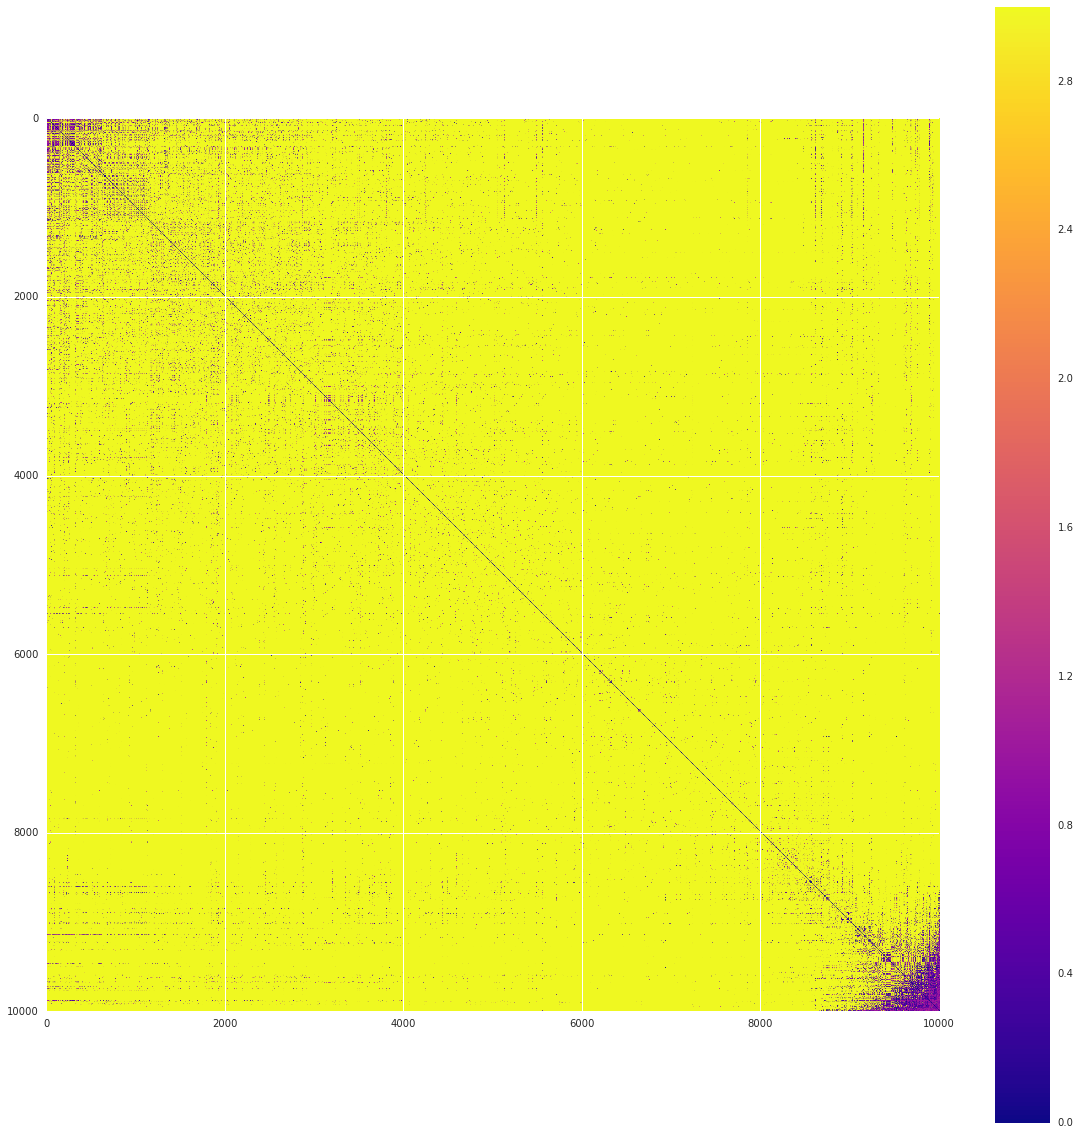

In [20]:
pl.figure(figsize=(20,20))
pl.imshow(ordered_distance_matrix, cmap='plasma')
pl.colorbar()
pl.savefig('../plots/distance_matrix10000_kt.png')
del ordered_distance_matrix

In [11]:
# pl.hist(distance_matrix.sum(axis=1), bins=100)
# pl.vlines(distance_matrix.shape[0] - 1, 0, 250, colors='r')

# Plotting results


In [14]:
def plot_silhouettes(silhouette_values, labels):
    clusters = np.unique(labels)
    pl.figure()
    pl.title(str(clusters.shape[0]) + ' clusters. Avg silhouette =' + ('%.5f' % silhouette_values.mean()))
    y_lower = 20
    for i in clusters:
        cluster_silhouette_values = np.sort(silhouette_values[labels == i])
        y_upper = y_lower + cluster_silhouette_values.shape[0]

        cluster_silhouette_values = np.sort(silhouette_values[labels == i])
        pl.fill_betweenx(np.arange(y_lower,y_upper),
                           0, cluster_silhouette_values, facecolor=pl.cm.spectral(i/clusters.shape[0]), alpha=0.6)
        pl.text(-0.05, y_lower + 0.5 * cluster_silhouette_values.shape[0], str(i))
        y_lower = y_upper + 10
    pl.axvline(x=silhouette_values.mean(), color="red", linestyle="--")    

## Single linkage

In [23]:
import sys
sys.setrecursionlimit(10000)

## find some pairs of objects within clusters to see whether it's meaningful
## change the source to work with NAN (average, median)
## put dendograms to report
## N > 3000 DONE
## data preprocessing chapter

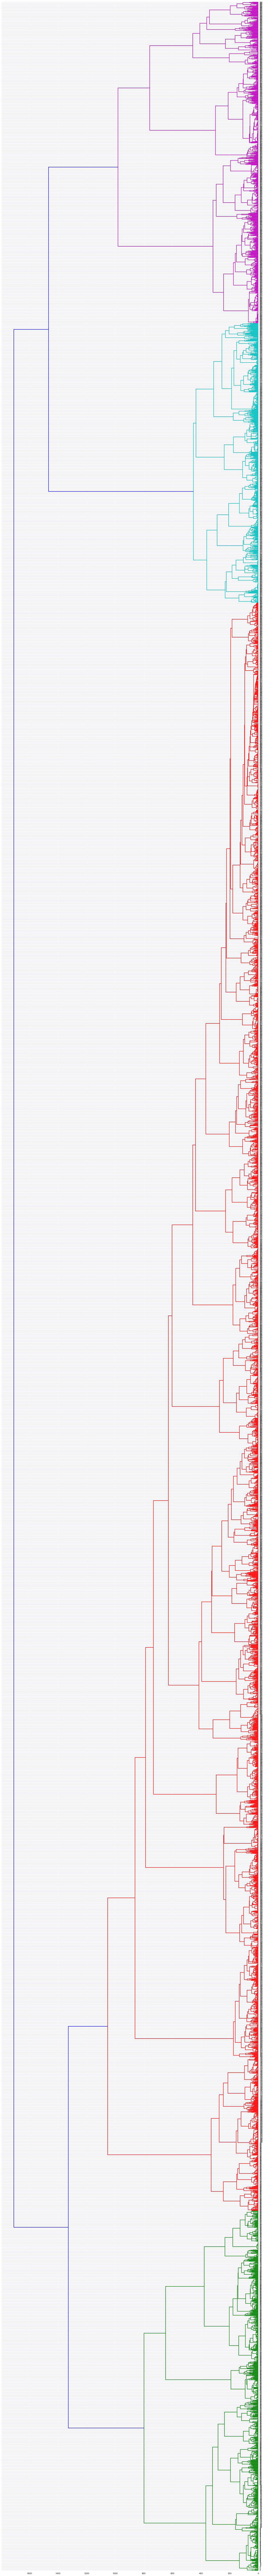

In [16]:
pl.figure(figsize=(20, 200))
dend = dendrogram(linkage(distance_matrix, method='ward'), orientation='left')
pl.savefig('../plots/ward_dendrogram.png')

In [32]:
# pl.figure(figsize=(20, 100))
# dend = dendrogram(linkage(distance_matrix, method='single'), orientation='left', truncate_mode='lastp', p=30)

## DBSCAN

silhouette = 0.0484292798186


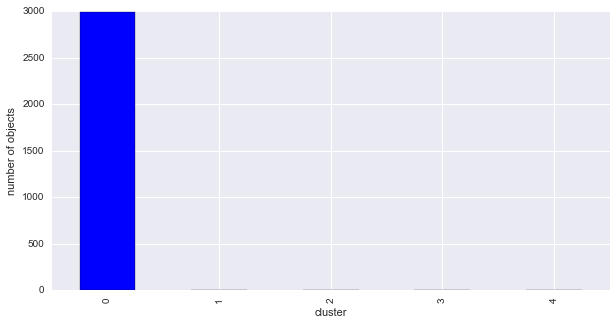

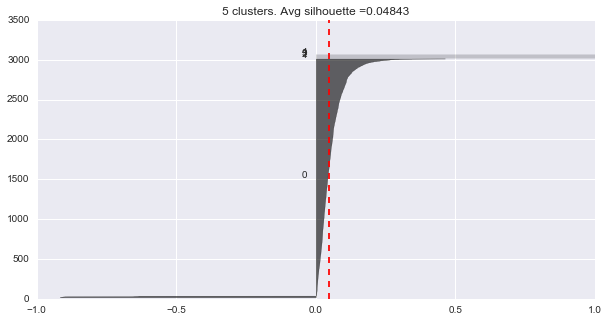

In [73]:
remove_noise = False
clustering = DBSCAN(metric='precomputed', eps=0.0001, min_samples=1)
labels = clustering.fit_predict(distance_matrix)
if remove_noise:
    labels = labels[labels >= 0]
pd.Series(labels).value_counts().sort_index().plot(kind='bar')
pl.xlabel('cluster')
pl.ylabel('number of objects')
silhouette_values = sklearn.metrics.silhouette_samples(distance_matrix, labels, metric='precomputed')
print('silhouette =', silhouette_values.mean())
plot_silhouettes(silhouette_values, labels)

# KMeans with SVD and euclidian metric

In [74]:
u,s,v = scipy.sparse.linalg.svds(X.astype('f'), k=7)
u.shape, s.shape, v.shape

((3000, 7), (7,), (7, 405632))

In [1]:
# sns.pairplot(u[:, 0], u[:, 1])

In [ ]:
ks = np.arange(2,25)
silhouettes = np.zeros(ks.shape[0])
for i, k in enumerate(ks):
    clustering = KMeans(n_clusters=k)
    labels = clustering.fit_predict(u)
    if remove_noise:
        labels = labels[labels >= 0]
    silhouettes[i] = sklearn.metrics.silhouette_score(u, labels)
    print(k, silhouettes[i])
pl.plot(ks, silhouettes, '--*')
pl.xlabel('alpha')
pl.ylabel('average silhouette')
n_clusters = ks[np.argmax(silhouettes)]
# n_clusters = 13

In [ ]:
clustering = KMeans(n_clusters=n_clusters)
labels = clustering.fit_predict(u)
if remove_noise:
    labels = labels[labels >= 0]
pd.Series(labels).value_counts().sort_index().plot(kind='bar')
pl.xlabel('cluster')
pl.ylabel('number of objects')
silhouette_values = sklearn.metrics.silhouette_samples(u, labels)
plot_silhouettes(silhouette_values, labels)


In [ ]:
clustering = KMeans(n_clusters=n_clusters)
labels = clustering.fit_predict(u)
df = pd.DataFrame(u[:, :5])
df['labels'] = labels
sns.pairplot(df, hue='labels')